In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.iotools import read_tmy3
from pvlib.pvsystem import PVSystem, FixedMount, Array
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.location import Location
import datetime
import math
import pytz
import os
import itertools
import inspect
import calendar
import h5py
from pvlib import pvsystem, location, modelchain, iotools,tools
import pathlib
from dataclasses import dataclass
from pvlib import tracking
from netCDF4 import num2date
from requests.exceptions import HTTPError
from xml.etree.ElementTree import ParseError
from pvlib.irradiance import campbell_norman, get_extra_radiation, disc, louche, erbs_driesse, ghi_from_poa_driesse_2023
from pvlib.irradiance import _liujordan, get_total_irradiance
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import warnings
from pvlib._deprecation import deprecated
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

In [2]:
#BSRN QC
data_path ='ALEX_BAY_2017M.csv'
df = pd.read_csv(data_path, index_col=[0], parse_dates=[0])
df.index = df.index.tz_localize('Africa/Johannesburg')  # Make the index timezone aware
original_entries = df.shape[0]
df.head(2)  # Print the first two lines of the DataFrame

,ghi,dhi,dni,temp_air,relative_humidity,tcc
DATE,,,,,,
2017-01-01 00:00:00+02:00,0.0,0.0,0.0,17.58,85.2,12
2017-01-01 00:01:00+02:00,0.0,0.0,0.0,17.58,85.3,12


In [3]:
latitude=-28.56084; longitude=16.76146; altitude=141; tz='Africa/Johannesburg'
location = Location(latitude,longitude,name='ALEXBAY', altitude=141, tz=tz)
datetime_or_doy=df.index
times=df.index
times

DatetimeIndex(['2017-01-01 00:00:00+02:00', '2017-01-01 00:01:00+02:00',
               '2017-01-01 00:02:00+02:00', '2017-01-01 00:03:00+02:00',
               '2017-01-01 00:04:00+02:00', '2017-01-01 00:05:00+02:00',
               '2017-01-01 00:06:00+02:00', '2017-01-01 00:07:00+02:00',
               '2017-01-01 00:08:00+02:00', '2017-01-01 00:09:00+02:00',
               ...
               '2017-12-31 23:50:00+02:00', '2017-12-31 23:51:00+02:00',
               '2017-12-31 23:52:00+02:00', '2017-12-31 23:53:00+02:00',
               '2017-12-31 23:54:00+02:00', '2017-12-31 23:55:00+02:00',
               '2017-12-31 23:56:00+02:00', '2017-12-31 23:57:00+02:00',
               '2017-12-31 23:58:00+02:00', '2017-12-31 23:59:00+02:00'],
              dtype='datetime64[ns, Africa/Johannesburg]', name='DATE', length=525600, freq=None)

In [4]:
solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
apparent_zenith = solpos['apparent_zenith']
zenith = solpos['zenith']
solar_zenith=solpos['apparent_zenith']
azimuth = solpos['azimuth']
equation_of_time=solpos['equation_of_time']
cos_solar_zenith=tools.cosd(solar_zenith)
pressure = pvlib.atmosphere.alt2pres(altitude)
linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude,longitude)
apparent_elevation = solpos['apparent_elevation']
dni_extra=pvlib.irradiance.get_extra_radiation(times, solar_constant=1367, method='spencer', epoch_year=2017)
#airmass_relative4=pvlib.atmosphere.get_relative_airmass(apparent_zenith, model='kastenyoung1989')
airmass_relative=pvlib.atmosphere.get_relative_airmass(apparent_zenith, model='gueymard2003')
absolute_airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

In [5]:
df['solar_zenith']=solar_zenith
#cos_solar_zenith=tools.cosd(solar_zenith)
df['cos_solar_zenith']=cos_solar_zenith
df['dni_extra']=dni_extra
ghi_extra = dni_extra * tools.cosd(solar_zenith)
df['ghi_extra']=ghi_extra
#df['dni_extra']=dni_extra
df['k_t']=df['ghi']/df['ghi_extra']  # clearness index
df['zenith']=zenith
df['airmass']=airmass_relative
cos_zen_gte_0 = cos_solar_zenith > 0
df['cos_zen_gte_0']=cos_zen_gte_0
# Calculate the day of the year
#day_of_year = times.timetuple().tm_yday
df['DOY'] = df.index.dayofyear
#df['DOY'] 
df['TL']=linke_turbidity

In [6]:
clearsky, meta =pvlib.iotools.get_cams(latitude=latitude, longitude=longitude, start=df.index[0], end=df.index[-1], email='brightmabasa@gmail.com',
                                       identifier='mcclear', altitude=altitude, time_step='1min', time_ref='UT', verbose=False, integrated=False, label=None, map_variables=True, server='api.soda-solardata.com', timeout=30)

In [7]:
df['ghi_McClear']=clearsky['ghi_clear']
df['dni_McClear']=clearsky['dni_clear']
df['dhi_McClear']=clearsky['dhi_clear']
#bhi_Mclear=clearsky['bhi_clear']
#df['ghi_extra_Mclear']=clearsky['ghi_extra']

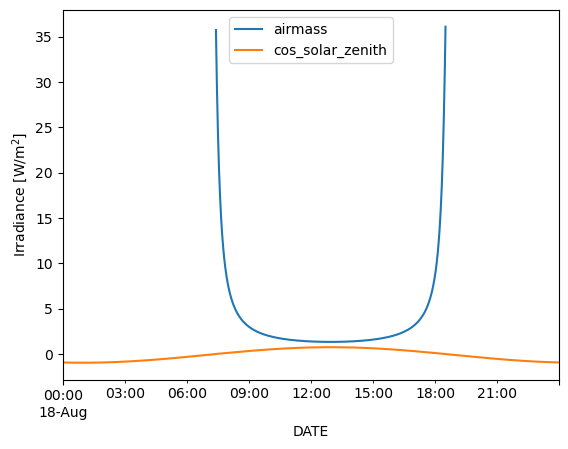

In [8]:
df.loc['2017-08-18', ['airmass','cos_solar_zenith']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [9]:
#pvlib.clearsky.detect_clearsky
#pvlib.clearsky.detect_clearsky(measured, clearsky, times=None, infer_limits=False, window_length=10, mean_diff=75, max_diff=75,
#lower_line_length=-5, upper_line_length=10, var_diff=0.005, slope_dev=8, max_iterations=20, return_components=False)
#Detects clear sky times using the algorithm developed by Reno and Hansen.
#The algorithm [1] was designed and validated for analyzing GHI time series. 
#Jordan and Hansen [2] extended the algorithm to plane-of-array (POA) irradiance measurements.
#The algorithm [1] detects clear sky times by comparing statistics for a measured time series and an expected clearsky time
#series. Statistics are calculated using a sliding time window (e.g., 10 minutes). An iterative algorithm identifies clear 
#periods, uses the identified periods to estimate bias in the clearsky data, scales the clearsky data and repeats.
#Clear times are identified by meeting five criteria. Default values for these thresholds are appropriate for 10 minute windows 
#of 1 minute GHI data. For data at longer intervals, it is recommended to set infer_limits=True to use the thresholds from [2].
#For POA data, clearsky must be on the same plane as measured.

In [10]:
#Parameters
#measured (array or Series) – Time series of measured GHI. [W/m2]
#clearsky (array or Series) – Time series of the expected clearsky GHI. [W/m2]
#times (DatetimeIndex, optional) – Times of measured and clearsky values. If not specified, the index of measured will be used.
#infer_limits (bool, default False) – If True, does not use passed in kwargs (or defaults), but instead interpolates these values from Table 1 in [2].
#window_length (int, default 10) – Length of sliding time window in minutes. Each window must contain at least three data points.
#mean_diff (float, default 75) – Threshold value for agreement between mean values of measured and clearsky in each interval, see Eq. 6 in [1]. [W/m2]
#max_diff (float, default 75) – Threshold value for agreement between maxima of measured and clearsky values in each interval, see Eq. 7 in [1]. [W/m2]
#lower_line_length (float, default -5) – Lower limit of line length criterion from Eq. 8 in [1].
#upper_line_length (float, default 10) – Upper limit of line length criterion from Eq. 8 in [1].
#var_diff (float, default 0.005) – Threshold value in Hz for the agreement between normalized standard deviations of rate of change in irradiance, see Eqs. 9 through 11 in [1].
#slope_dev (float, default 8) – Threshold value for agreement between the largest magnitude of change in successive values, see Eqs. 12 through 14 in [1].
#max_iterations (int, default 20) – Maximum number of times to apply a different scaling factor to the clearsky and redetermine clear_samples. Must be 1 or larger.
#return_components (bool, default False) – Controls if additional output should be returned. See below.
#Returns:
#clear_samples (array or Series) – Boolean array or Series of whether or not the given time is clear. 
#Return type is the same as the input type.
#components (OrderedDict, optional) – Dict of arrays of whether or not the given time window is clear for each condition. 
#Only provided if return_components is True.
#alpha (scalar, optional) – Scaling factor applied to clearsky to obtain the detected clear_samples. 
#Only provided if return_components is True.
#Raises:
#ValueError – If measured is not a Series and times is not provided.
#ValueError – If a window contains less than three data points.
#ValueError – If the measured data is not sufficient to fill a window.
#NotImplementedError – If timestamps are not equally spaced

In [11]:
#Detect Clearsky
#The detect_clearsky() function implements the [Ren16] algorithm to detect the clear and cloudy points of a time series. 
#The algorithm was designed and validated for analyzing GHI time series only. Users may attempt to apply it to other types of 
#time series data using different filter settings, but should be skeptical of the results.
#The algorithm detects clear sky times by comparing statistics for a measured time series and an expected clearsky time series. 
#Statistics are calculated using a sliding time window (e.g., 10 minutes).
#An iterative algorithm identifies clear periods, uses the identified periods to estimate bias in the clearsky data, 
#scales the clearsky data and repeats.
#Clear times are identified by meeting 5 criteria. Default values for these thresholds are appropriate for 10 minute windows
#of 1 minute GHI data.
#Next, we show a simple example of applying the algorithm to synthetic GHI data. 
#We first generate and plot the clear sky and measured data

In [12]:
#abq = Location(35.04, -106.62, altitude=1619)
#times = pd.date_range(start='2012-04-01 10:30:00', tz='Etc/GMT+7', periods=30, freq='1min')
#cs = abq.get_clearsky(times)
#scale clear sky data to account for possibility of different turbidity
#ghi = cs['ghi']*.953
# add a cloud event
#ghi['2012-04-01 10:42:00':'2012-04-01 10:44:00'] = [500, 300, 400]
# add an overirradiance event
#ghi['2012-04-01 10:56:00'] = 950

#fig, ax = plt.subplots()

#ghi.plot(label='input');

#cs['ghi'].plot(label='ineichen clear');

#ax.set_ylabel('Irradiance $W/m^2$');

#plt.legend(loc=4);

In [13]:
#data_mean = data.values[H].mean(axis=0)
#data_mean = _to_centered_series(data_mean, data.index, samples_per_window)
#data_max = data.values[H].max(axis=0)
#data_max = _to_centered_series(data_max, data.index, samples_per_window)
#shift to get forward difference, .diff() is backward difference instead
#data_diff = data.diff().shift(-1)
#data_slope = data_diff / sample_interval
#data_slope_nstd = _slope_nstd_windowed(data_slope.values[:-1], data, H,samples_per_window, sample_interval)
#return data_mean, data_max, data_slope_nstd, data_slope

In [14]:
#DetectsClearSkyTimes

In [15]:
DetectsClearSkyTimes_GHI=pvlib.clearsky.detect_clearsky(df.ghi, df.ghi_McClear, times=times, infer_limits=False, window_length=10,
mean_diff=100, max_diff=100, lower_line_length=-50, upper_line_length=50, var_diff=0.01, slope_dev=10, max_iterations=20)

In [16]:
#DetectsClearSkyTimes_DHI=pvlib.clearsky.detect_clearsky(df.ghi, df.dhi_McClear, times=times, infer_limits=False, window_length=10,
#mean_diff=75, max_diff=75, lower_line_length=-5, upper_line_length=10, var_diff=0.005, slope_dev=8, max_iterations=5)

In [17]:
#DetectsClearSkyTimes_DNI=pvlib.clearsky.detect_clearsky(df.dni, df.dni_McClear, times=times, infer_limits=False, window_length=10,
#mean_diff=200, max_diff=200, lower_line_length=-100, upper_line_length=100, var_diff=0.0015, slope_dev=15, max_iterations=20)

In [18]:
df['DetectsClearSkyTimes_GHI']=DetectsClearSkyTimes_GHI
#df['DetectsClearSkyTimes_DNI']=DetectsClearSkyTimes_DNI

In [19]:
df.describe()

,ghi,dhi,dni,temp_air,relative_humidity,tcc,solar_zenith,cos_solar_zenith,dni_extra,ghi_extra,k_t,zenith,airmass,DOY,TL,ghi_McClear,dni_McClear,dhi_McClear
count,525599.000000,523425.000000,523066.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525599.000000,525600.000000,264138.000000,525600.000000,525600.000000,525480.000000,525480.000000,525480.000000
mean,260.911993,48.583092,340.290351,18.300536,59.645040,13.786301,90.228767,-0.002791,1367.150379,0.514788,0.324820,90.256430,3.616185,183.000000,3.905361,283.631611,388.734126,42.875357
std,351.458224,76.942621,422.758632,6.501151,23.888253,22.112271,41.568004,0.611112,33.109086,835.739852,2.463413,41.558885,5.198406,105.366129,0.420237,367.634356,428.886872,51.364310
min,0.000000,0.000000,0.000000,0.995000,2.795000,0.000000,5.125071,-0.995999,1321.326581,-1320.287347,-507.670160,5.126556,1.003808,1.000000,3.201613,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,13.740000,41.050000,0.000000,55.050373,-0.578647,1334.042275,-796.395115,-0.000000,55.074395,1.300191,92.000000,3.500000,0.000000,0.000000,0.000000
50%,3.744670,2.528840,0.000000,17.340000,61.955833,2.000000,89.679524,0.005593,1366.225284,7.635675,0.089860,90.188919,1.748803,183.000000,3.947541,0.000000,0.000000,0.000000
75%,531.090500,75.128600,835.409750,22.330000,80.400000,19.000000,125.355423,0.572856,1400.160695,776.379402,0.724492,125.355423,3.201598,274.000000,4.295082,590.712000,866.292000,84.330000
max,1661.180000,842.041000,1131.520000,44.640000,100.000000,100.000000,174.873061,0.996002,1414.950771,1408.611681,1507.846257,174.873061,38.180092,365.000000,4.500000,1178.670000,1109.616000,334.638000


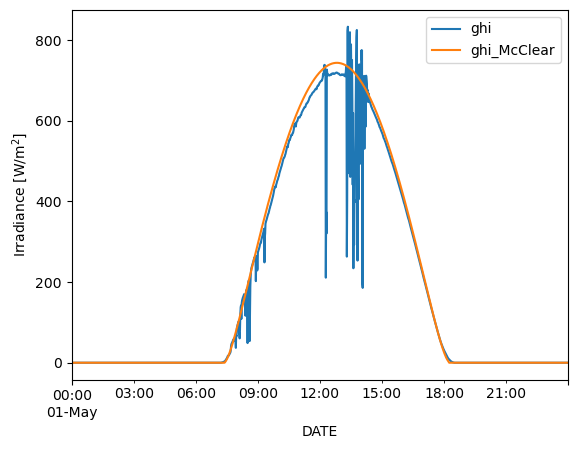

In [20]:
df.loc['2017-05-01', ['ghi','ghi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

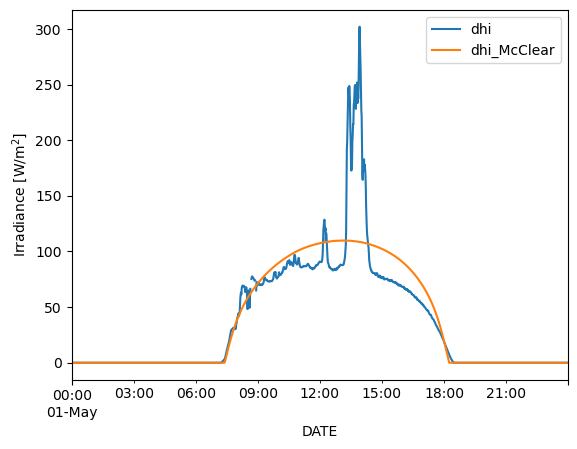

In [21]:
df.loc['2017-05-01', ['dhi','dhi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

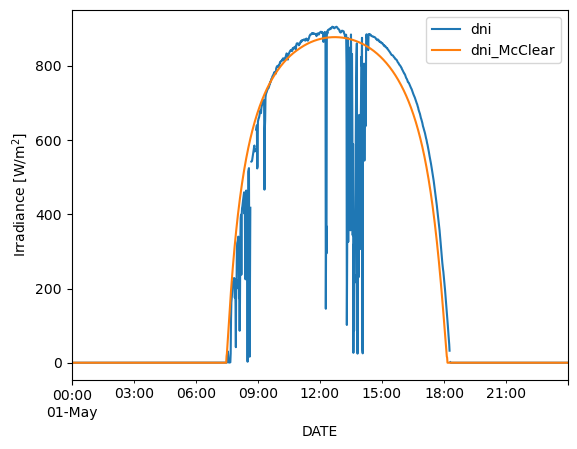

In [22]:
df.loc['2017-05-01', ['dni','dni_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

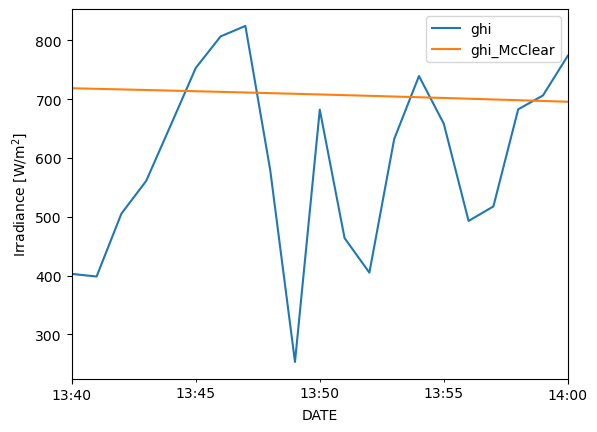

In [23]:
df.loc['2017-05-01 13:40:00':'2017-05-01 14:00:00', ['ghi','ghi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

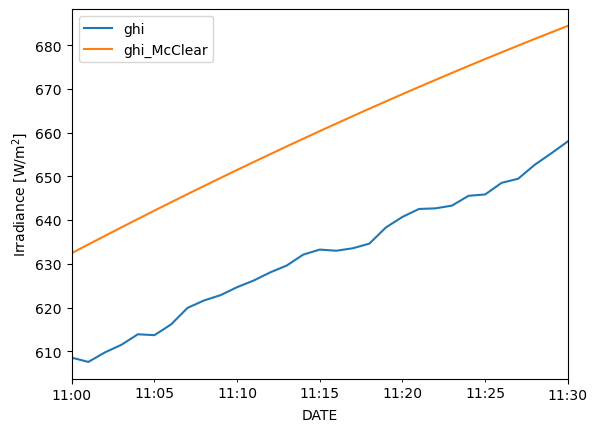

In [24]:
df.loc['2017-05-01 11:00:00':'2017-05-01 11:30:00', ['ghi','ghi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

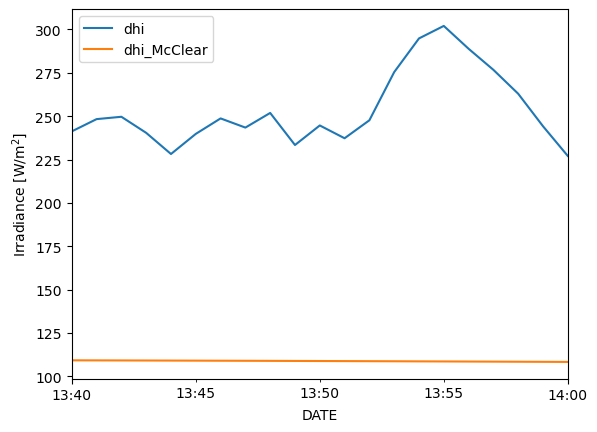

In [25]:
df.loc['2017-05-01 13:40:00':'2017-05-01 14:00:00', ['dhi','dhi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

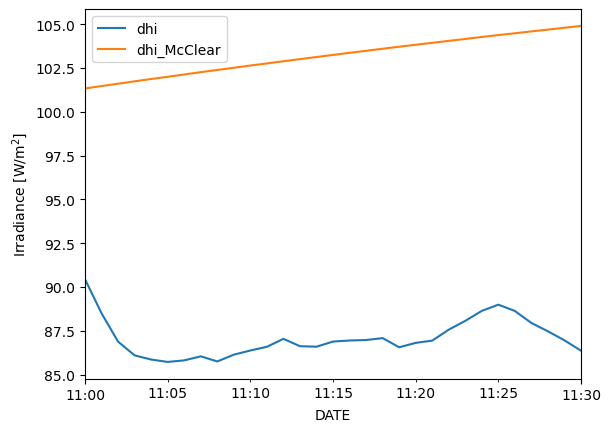

In [26]:
df.loc['2017-05-01 11:00:00':'2017-05-01 11:30:00', ['dhi','dhi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

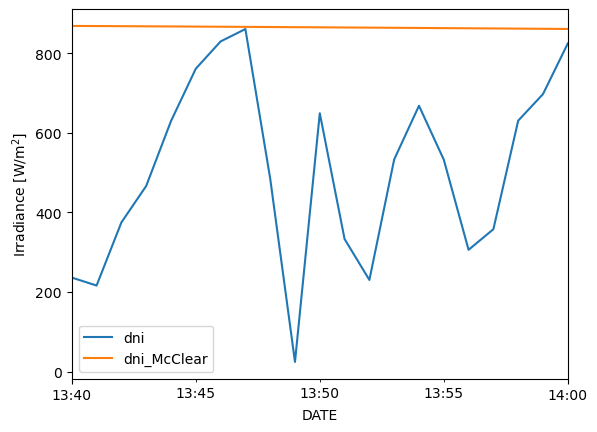

In [27]:
df.loc['2017-05-01 13:40:00':'2017-05-01 14:00:00', ['dni','dni_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

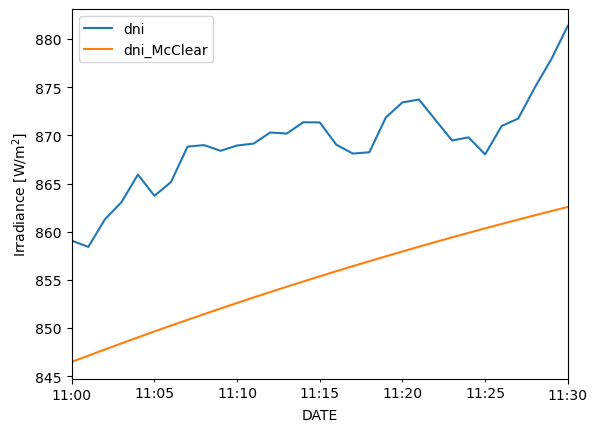

In [28]:
df.loc['2017-05-01 11:00:00':'2017-05-01 11:30:00', ['dni','dni_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [29]:
# Set GHI and DNI to NaN if DetectsClearSkyTimes is False
df.loc[~df['DetectsClearSkyTimes_GHI'], 'ghi'] = np.nan
# Set DHI and DNI to NaN if DetectsClearSkyTimes is False
#df.loc[~df['DetectsClearSkyTimes_GHI'], 'dhi'] = np.nan
# Set DNI and DHI to NaN if DetectsClearSkyTimes is False
#f.loc[~df['DetectsClearSkyTimes_GHI'], 'dni'] = np.nan

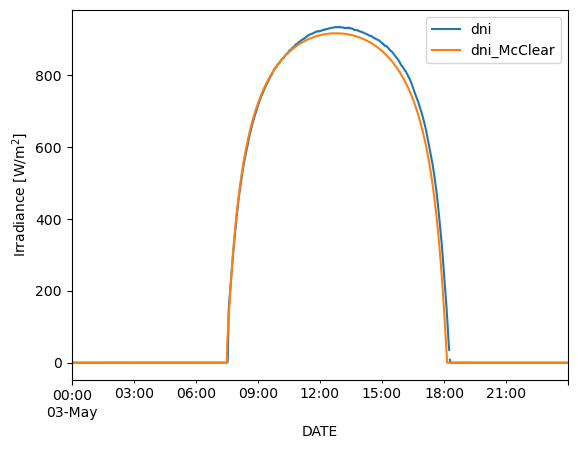

In [30]:
df.loc['2017-05-03', ['dni','dni_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

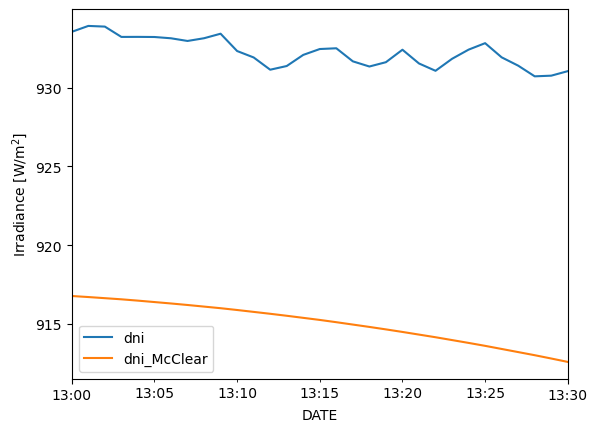

In [31]:
df.loc['2017-05-03 13:00:00':'2017-05-03 13:30:00', ['dni','dni_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

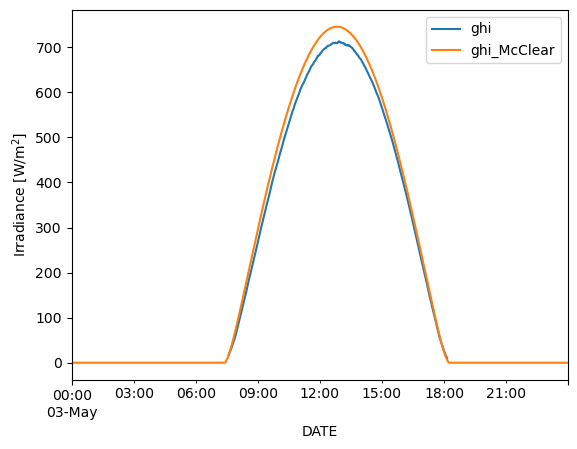

In [32]:
df.loc['2017-05-03', ['ghi','ghi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

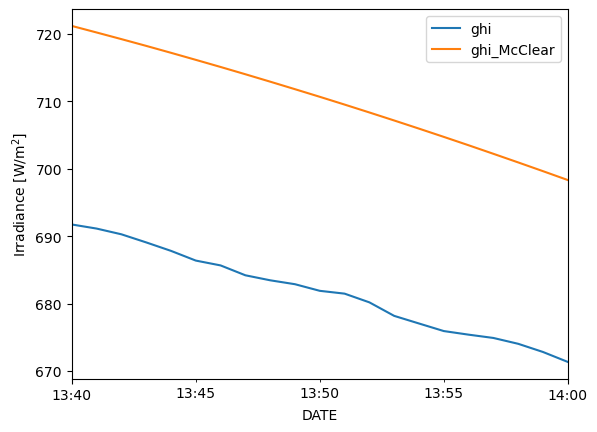

In [33]:
df.loc['2017-05-03 13:40:00':'2017-05-03 14:00:00', ['ghi','ghi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

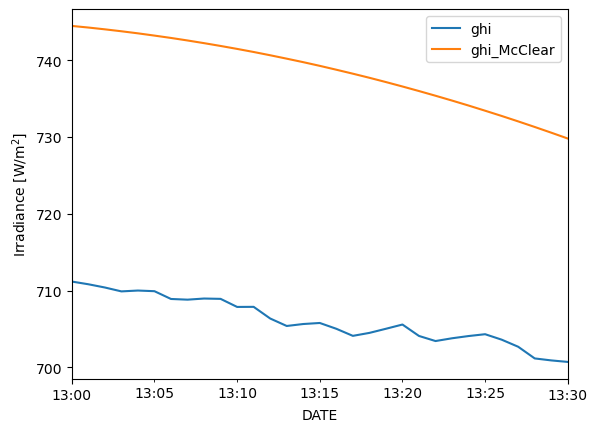

In [34]:
df.loc['2017-05-03 13:00:00':'2017-05-03 13:30:00', ['ghi','ghi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [35]:
(b1,b2)=(0.8715975569729236,-0.08411115945093153)
Site_GHIcs = b1 * df.ghi_extra * np.exp(b2 * df.airmass)
Site_GHIcs[Site_GHIcs < 0] = 0
df['Site_GHIcs']=Site_GHIcs

In [36]:
(b1,b2)=(0.8246822575631855,-0.06561057654240751)
Climate_GHIcs = b1 * df.ghi_extra * np.exp(b2 * df.airmass)
Climate_GHIcs[Climate_GHIcs < 0] = 0
df['Climate_GHIcs']=Climate_GHIcs

In [37]:
(b1,b2)=(0.858699465241646,-0.07340751343495265)
National_GHIcs = b1 * df.ghi_extra * np.exp(b2 * df.airmass)
National_GHIcs[National_GHIcs < 0] = 0
df['National_GHIcs']=National_GHIcs

In [38]:
#(a,b)=(1114.94725247204,-0.13895250135742981)
#1114.94725247204,-0.13895250135742981
#Site_DNIcs = df.ghi_extra * np.exp (df.airmass * b )
#Site_DNIcs [Site_DNIcs < 0] = 0
#df['Site_DNIcs']=Site_DNIcs

#a = 0.7923
    #b = 0.8834
    #return a * (b ** airmass) * extraterrestrial_radiation
#(a,b)=(0.7923, 0.8834)
#df['Site_DNIcs'] = a * (b **df.airmass) * df.dni_extra

In [39]:
#(a,b)=(1116.312283471325,-0.01934736973743606)
#Site_DNIcs = df.dni_extra * a ** (df.airmass * b )
#Site_DNIcs [Site_DNIcs < 0] = 0
#df['Site_DNIcs']=Site_DNIcs

In [40]:
(a,b)=(95.8369300584677,1.4418474462152773)
Site_DHIcs = a * tools.cosd(solar_zenith)**b*df.airmass
Site_DHIcs [Site_DHIcs < 0] = 0
df['Site_DHIcs']=Site_DHIcs

In [41]:
(a,b)=(84.69770685002509,1.3927231119294705)
Climate_DHIcs = a * tools.cosd(solar_zenith)**b*df.airmass
Climate_DHIcs [Climate_DHIcs < 0] = 0
df['Climate_DHIcs']=Climate_DHIcs

In [42]:
(a,b)=(112.07306428246687,1.59792698097973)
National_DHIcs = a * tools.cosd(solar_zenith)**b*df.airmass
National_DHIcs [National_DHIcs < 0] = 0
df['National_DHIcs']=National_DHIcs

In [43]:
(a,b)= (1114.9723719593546, 0.8702009689897141)
Site_DNIcs = a * (b)**df.airmass
Site_DNIcs [Site_DNIcs < 0] = 0
df['Site_DNIcs']=Site_DNIcs

In [44]:
(a,b)= (1159.0751801404924, 0.8732714196614305)
Climate_DNIcs = a * (b)**df.airmass
Climate_DNIcs [Climate_DNIcs < 0] = 0
df['Climate_DNIcs']=Climate_DNIcs

In [45]:
(a,b)= (1085.5868821684878, 0.8829571531306774)
National_DNIcs = a * (b)**df.airmass
National_DNIcs [National_DNIcs < 0] = 0
df['National_DNIcs']=National_DNIcs

In [46]:
Ineichen_DNIcs=df.dni_extra* np.exp (-0.16-0.22* df.airmass) 
Ineichen_DNIcs [Ineichen_DNIcs < 0] = 0
df['Ineichen_DNIcs']=Ineichen_DNIcs

In [47]:
(a, b)= (-0.23282223648069525, -0.12402231736198209)
Ineichen1_DNIcs=df.dni_extra* np.exp (a + b* df.airmass) 
Ineichen1_DNIcs [Ineichen1_DNIcs < 0] = 0
df['Ineichen1_DNIcs']=Ineichen1_DNIcs     

In [48]:
(a,b)= (-0.19062110682833852, -0.12240163515408421)
IneichenC_DNIcs=df.dni_extra* np.exp (a + b* df.airmass) 
IneichenC_DNIcs [IneichenC_DNIcs < 0] = 0
df['IneichenC_DNIcs']=IneichenC_DNIcs

In [49]:
(a,b)= ( -0.24972924163501165, -0.11048021333641239)
IneichenN_DNIcs=df.dni_extra* np.exp (a + b* df.airmass) 
IneichenN_DNIcs [IneichenN_DNIcs < 0] = 0
df['IneichenN_DNIcs']=IneichenN_DNIcs

In [50]:
(a, b) = (0.8067258983737214, 1.1343452571642194   )
PdBV1_GHIcs = a * df.dni_extra * tools.cosd(solar_zenith)** b
PdBV1_GHIcs [PdBV1_GHIcs < 0] = 0
df['PdBV1_GHIcs']=PdBV1_GHIcs

In [51]:
(a, b) = (0.8170469614788132, 1.1193603250628639)
PdBVC_GHIcs = a * df.dni_extra * tools.cosd(solar_zenith)** b
PdBVC_GHIcs [PdBVC_GHIcs < 0] = 0
df['PdBVC_GHIcs']=PdBVC_GHIcs

In [52]:
(a, b) = (0.8051037400119986, 1.1252779898365388)
PdBVN_GHIcs = a * df.dni_extra * tools.cosd(solar_zenith)** b
PdBVN_GHIcs [PdBVN_GHIcs < 0] = 0
df['PdBVN_GHIcs']=PdBVN_GHIcs

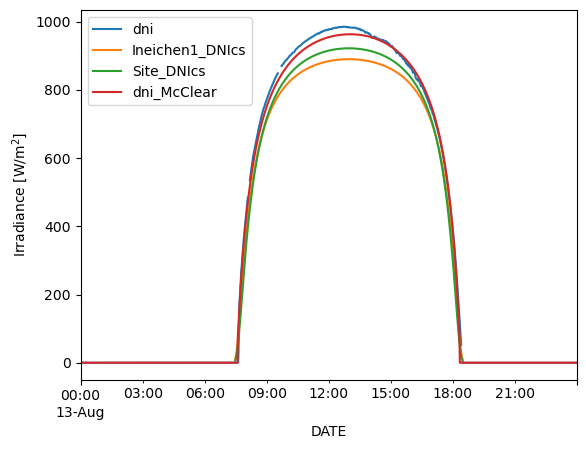

In [53]:
df.loc['2017-08-13', ['dni','Ineichen1_DNIcs','Site_DNIcs','dni_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [54]:
#df['Site_DNIcs']=(df['Site_GHIcs']-df['Site_DHIcs'])/ tools.cosd(solar_zenith) 

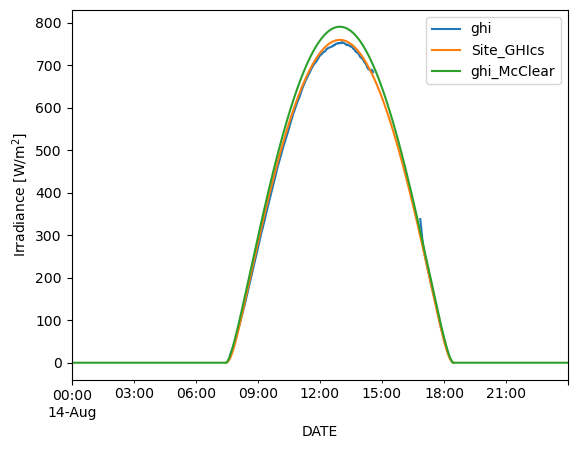

In [55]:
df.loc['2017-08-14', ['ghi','Site_GHIcs','ghi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

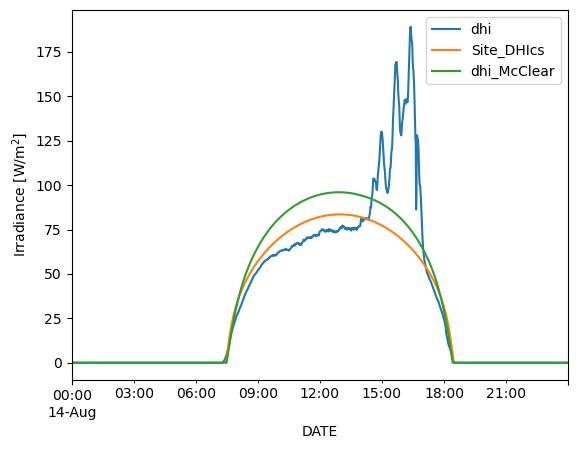

In [56]:
df.loc['2017-08-14', ['dhi','Site_DHIcs','dhi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

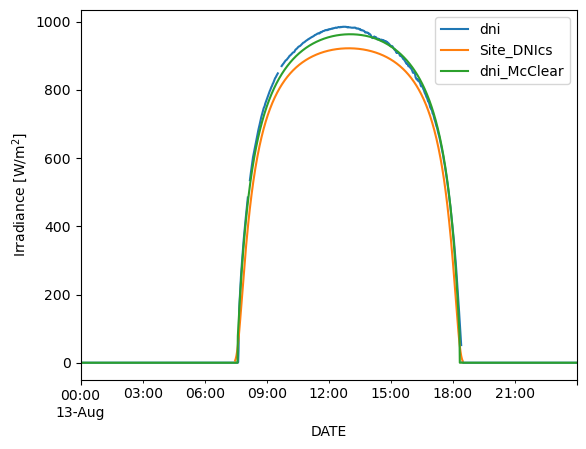

In [57]:
df.loc['2017-08-13', ['dni','Site_DNIcs', 'dni_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [58]:
#Simplified_Solis
SS=pvlib.clearsky.simplified_solis(apparent_elevation, aod700=0.1, precipitable_water=1, pressure=pressure, dni_extra=dni_extra)
ghi_clearSS=SS['ghi']
dni_clearSS=SS['dni']
dhi_clearSS=SS['dhi']
df['SS_GHIcs']=ghi_clearSS
df['SS_DHIcs']=dhi_clearSS
df['SS_DNIcs']=dni_clearSS

In [59]:
#Ineichen&Perez
IP = pvlib.clearsky.ineichen(apparent_zenith, absolute_airmass, linke_turbidity, altitude, dni_extra,perez_enhancement=True)
ghi_clearIP=IP['ghi']
dni_clearIP=IP['dni']
dhi_clearIP=IP['dhi']
df['IP_GHIcs']=ghi_clearIP
df['IP_DHIcs']=dhi_clearIP
df['IP_DNIcs']=dni_clearIP

In [60]:
#Berger–Duffie (BD)#BD_GHI = DNI_TOA* (0.70*cosa)
BD_GHI = 0.7* dni_extra  * cos_solar_zenith #945=1350*0.7
BD_GHI[BD_GHI < 0] = 0
df_out = pd.DataFrame({'ghi':BD_GHI})
BD_GHI
#BD_GHI.to_csv('BDM.csv')
df['BD_GHIcs']=BD_GHI

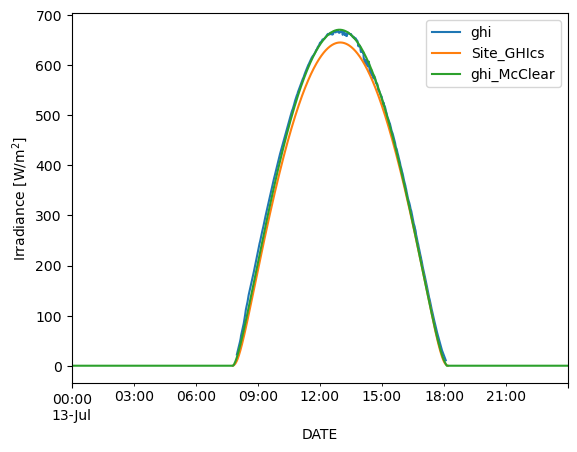

In [61]:
df.loc['2017-07-13', ['ghi','Site_GHIcs','ghi_McClear']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [62]:
BigaRosa_DHIcs = 131 * tools.cosd(solar_zenith)** 0.6
BigaRosa_DHIcs [BigaRosa_DHIcs < 0] = 0
df['BigaRosa_DHIcs']=BigaRosa_DHIcs

In [63]:
BigaRosa_DNIcs = 926 * tools.cosd(solar_zenith)**0.29
BigaRosa_DNIcs [BigaRosa_DNIcs < 0] = 0
df['BigaRosa_DNIcs']=BigaRosa_DNIcs

In [64]:
#EghBiga=1057*((cos(sza))^1.17)
BigaRosa_GHIcs = 1057 * tools.cosd(solar_zenith)** 1.17
BigaRosa_GHIcs [BigaRosa_GHIcs < 0] = 0
df['BigaRosa_GHIcs']=BigaRosa_GHIcs

In [65]:
Brichambaut_DHIcs = 125 * tools.cosd(solar_zenith)** 0.4
Brichambaut_DHIcs [Brichambaut_DHIcs < 0] = 0
df['Brichambaut_DHIcs']=Brichambaut_DHIcs

In [66]:
Brichambaut_GHIcs = 1080 * (tools.cosd(solar_zenith)) **1.22
Brichambaut_GHIcs [Brichambaut_GHIcs < 0] = 0
df['Brichambaut_GHIcs']=Brichambaut_GHIcs

In [67]:
df['Brichambaut_DNIcs']=(df['Brichambaut_GHIcs']-df['Brichambaut_DHIcs'])/ tools.cosd(solar_zenith) 

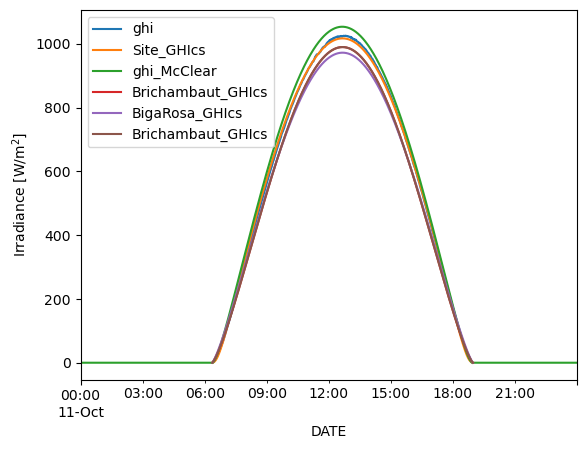

In [68]:
df.loc['2017-10-11', ['ghi','Site_GHIcs','ghi_McClear','Brichambaut_GHIcs','BigaRosa_GHIcs','Brichambaut_GHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

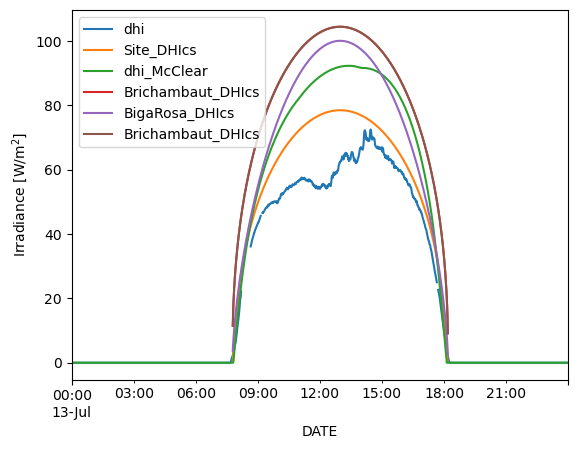

In [69]:
df.loc['2017-07-13', ['dhi','Site_DHIcs','dhi_McClear','Brichambaut_DHIcs','BigaRosa_DHIcs','Brichambaut_DHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

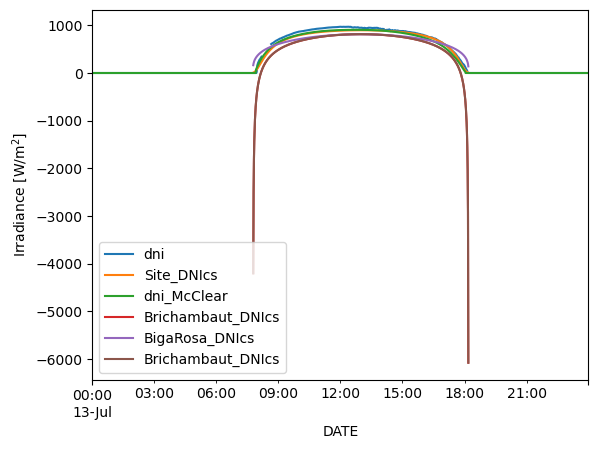

In [70]:
df.loc['2017-07-13', ['dni','Site_DNIcs','dni_McClear','Brichambaut_DNIcs','BigaRosa_DNIcs','Brichambaut_DNIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [71]:
Schulze_DHIcs = 94.23* (tools.cosd(solar_zenith))**(0.5)
Schulze_DHIcs [Schulze_DHIcs < 0] = 0
df['Schulze_DHIcs']=Schulze_DHIcs

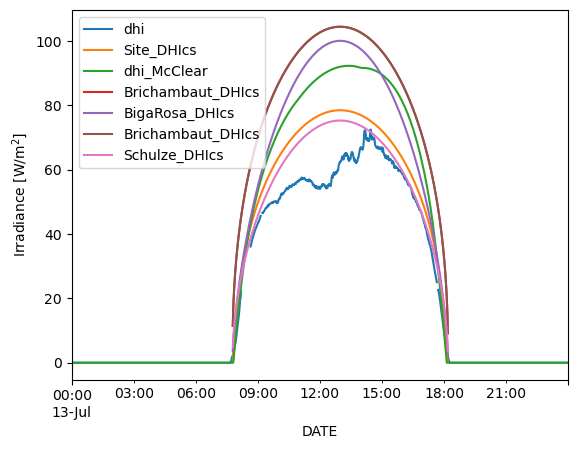

In [72]:
df.loc['2017-07-13', ['dhi','Site_DHIcs','dhi_McClear','Brichambaut_DHIcs','BigaRosa_DHIcs','Brichambaut_DHIcs','Schulze_DHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [73]:
Schulze_DNIcs = 1127* (0.888)**df.airmass
Schulze_DNIcs [Schulze_DNIcs < 0] = 0
df['Schulze_DNIcs']=Schulze_DNIcs

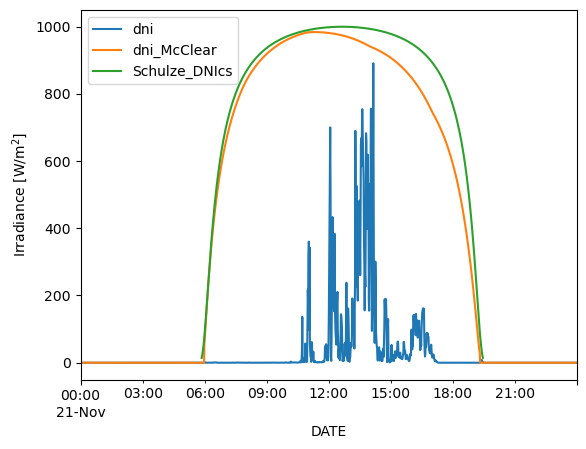

In [74]:
df.loc['2017-11-21', ['dni','dni_McClear','Schulze_DNIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [75]:
df['Schulze_GHIcs']= df['Schulze_DNIcs'] * tools.cosd(solar_zenith) + df['Schulze_DHIcs']

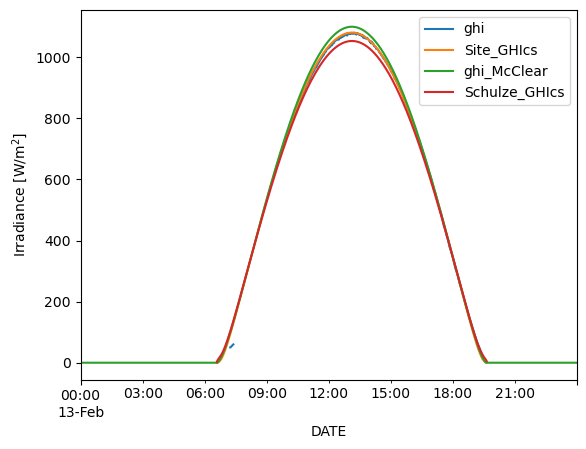

In [76]:
df.loc['2017-02-13', ['ghi','Site_GHIcs','ghi_McClear','Schulze_GHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [77]:
Haurwitz_GHIcs = (1098* cos_solar_zenith[cos_zen_gte_0] * np.exp (-0.057 / cos_solar_zenith [cos_zen_gte_0]))
Haurwitz_GHIcs [Haurwitz_GHIcs < 0] = 0
df['Haurwitz_GHIcs']=Haurwitz_GHIcs

In [78]:
HaurwitzM_GHIcs = (1164* cos_solar_zenith[cos_zen_gte_0] * np.exp (-0.071 / cos_solar_zenith [cos_zen_gte_0] ))
HaurwitzM_GHIcs [HaurwitzM_GHIcs < 0] = 0
df['HaurwitzM_GHIcs']=HaurwitzM_GHIcs

In [79]:
#Berger–Duffie (BD)#BD_GHI = DNI_TOA* (0.70*cosa)
BDM_GHIcs = 1051  * cos_solar_zenith #945=1350*0.7
BDM_GHIcs[BDM_GHIcs < 0] = 0
df_out = pd.DataFrame({'ghi':BDM_GHIcs})
BDM_GHIcs
#BD_GHI.to_csv('BDM.csv')
df['BDM_GHIcs']=BDM_GHIcs

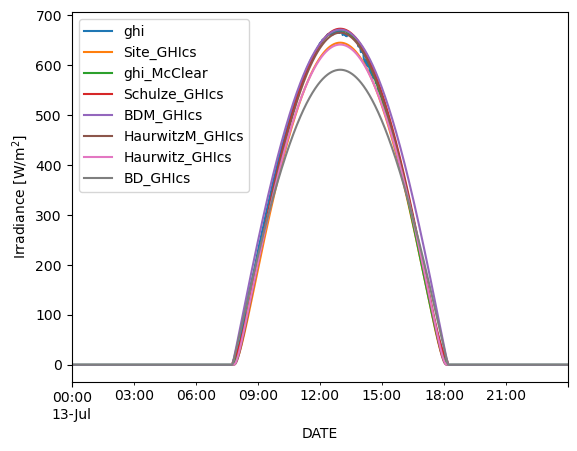

In [80]:
df.loc['2017-07-13', ['ghi','Site_GHIcs','ghi_McClear','Schulze_GHIcs','BDM_GHIcs','HaurwitzM_GHIcs','Haurwitz_GHIcs','BD_GHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [81]:
#Kasten–Czeplak (KC)
KC_GHIcs= 910 * cos_solar_zenith[cos_zen_gte_0] -30
KC_GHIcs [KC_GHIcs < 0] = 0
df['KC_GHIcs']=KC_GHIcs

In [82]:
#Kasten–Czeplak (KC)
KCM_GHIcs= 1124 * cos_solar_zenith[cos_zen_gte_0] -44
KCM_GHIcs [KCM_GHIcs < 0] = 0
df['KCM_GHIcs']=KCM_GHIcs

In [83]:
ABCG_GHIcs= 951.39 * (tools.cosd(solar_zenith)) ** (1.15)
ABCG_GHIcs [ABCG_GHIcs < 0] = 0
df['ABCG_GHIcs']=ABCG_GHIcs

In [84]:
ABCGM_GHIcs= 1125 * (tools.cosd(solar_zenith)) **(1.2)
ABCGM_GHIcs [ABCGM_GHIcs < 0] = 0
df['ABCGM_GHIcs']=ABCGM_GHIcs

In [85]:
RS_GHIcs=1159.24 * (cos_solar_zenith[cos_zen_gte_0])**1.179 *  np.exp (-0.0019 * (90-solar_zenith))  
RS_GHIcs [RS_GHIcs < 0] = 0
df['RS_GHIcs']=RS_GHIcs

In [86]:
#w=np.exp (-0.75 *(pi /2 - solar_zenith)
DPP_DNIcs= 950.2 * (1-(np.exp (-0.075 * (90- solar_zenith))))
DPP_DNIcs [DPP_DNIcs < 0] = 0
df['DPP_DNIcs']=DPP_DNIcs

In [87]:
DPP_DHIcs = 2.534 + 3.475 * (90 - solar_zenith)
#df['DPP_DHIcs'] = 2.534 + 3.475 * (90 - solar_zenith)
DPP_DHIcs [DPP_DHIcs < 0] = 0
df['DPP_DHIcs']=DPP_DHIcs

In [88]:
df['DPP_GHIcs']= df['DPP_DNIcs'] * tools.cosd(solar_zenith) + df['DPP_DHIcs']

In [89]:
Bulger_DHIcs= 16*(90 - solar_zenith)**0.5 - 0.4*(90 - solar_zenith)
Bulger_DHIcs [Bulger_DHIcs < 0] = 0
df['Bulger_DHIcs']=Bulger_DHIcs

In [90]:
###References:
#Yang, D., Walsh, W. M., & Jirutitijaroen, P. (2014). Estimation and applications of clear sky global horizontal 
#irradiance at the equator. Journal of Solar Energy Engineering, 136(3), 034505.
#global horizontal irradiance
YangWalsh_GHIcs=(0.8277 * df.dni_extra)*((tools.cosd(solar_zenith))**(1.3644)) * np.exp(-0.0013*(90-solar_zenith))
YangWalsh_GHIcs[YangWalsh_GHIcs < 0] = 0
df['YangWalsh_GHIcs']=YangWalsh_GHIcs 

In [91]:
##References:
#Sharma, M. R., & Pal, R. S. (1965). Interrelationships between total, direct, and diffuse solar radiation in the tropics. Solar Energy, 9(4), 183-192.
#Badescu, V., Gueymard, C. A., Cheval, S., Oprea, C., Baciu, M., Dumitrescu, A., ... & Rada, C. (2013). Accuracy analysis for fifty-four clear-sky solar radiation models using 
#routine hourly global irradiance measurements in Romania. Renewable Energy, 55, 85-103#EbnSharma=1.842*(Eext/2)*cos(sza)/(0.3135+cos(sza)) 
#global horizontal irradiance
#EghSharma=4.5*(Eext/(2*60))+1.071*EbnSharma*cos(sza) 
#diffuse horizontal irradiance
#EdhSharma=EghSharma-EbnSharma*cos(sza)

In [92]:
Meinel_DNIcs = df.dni_extra * 0.7**df.airmass**0.678
Meinel_DNIcs [Meinel_DNIcs < 0] = 0
df['Meinel_DNIcs']=Meinel_DNIcs

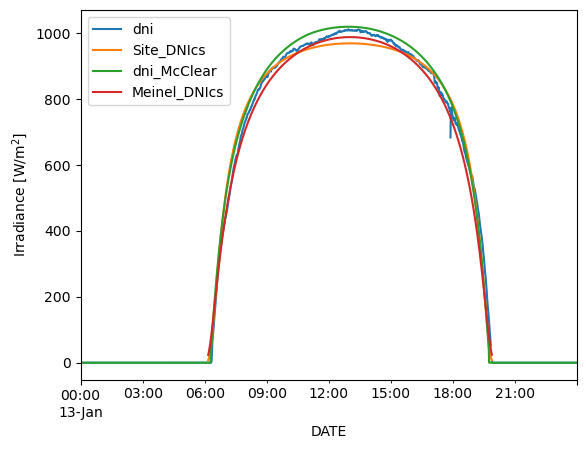

In [93]:
df.loc['2017-01-13', ['dni','Site_DNIcs','dni_McClear','Meinel_DNIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [94]:
#w=np.exp (-0.75 *(pi /2 - solar_zenith)
Sharma_DNIcs= 1.842* (df.dni_extra/2) * tools.cosd(solar_zenith)/ (0.3135 + tools.cosd(solar_zenith)) 
Sharma_DNIcs [Sharma_DNIcs < 0] = 0
df['Sharma_DNIcs']=Sharma_DNIcs

In [95]:
#w=np.exp (-0.75 *(pi /2 - solar_zenith)
Sharma_GHIcs= (4.5* (df.dni_extra/120)) + (1.071* df.Sharma_DNIcs * tools.cosd(solar_zenith))
Sharma_GHIcs [Sharma_GHIcs < 0] = 0
df['Sharma_GHIcs']=Sharma_GHIcs

In [96]:
df['Sharma_DHIcs'] = (df['Sharma_GHIcs']-df['Sharma_DNIcs'] * tools.cosd(solar_zenith))

In [97]:
lower=0
Sharma_DNIcs[Sharma_DNIcs <lower]=0
#Sharma_DHIcs[Sharma_DHIcs <lower]=0
Sharma_GHIcs[Sharma_GHIcs <lower]=0

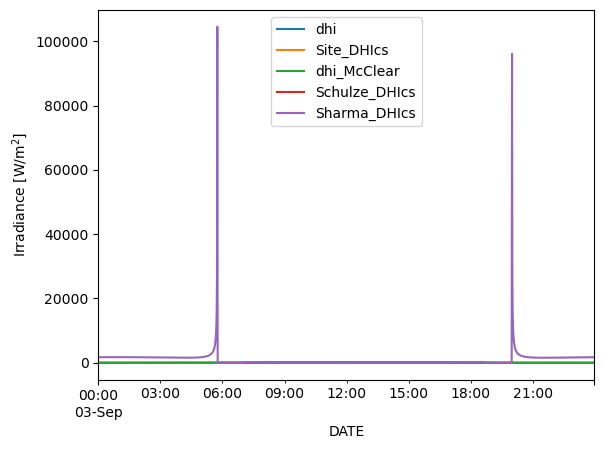

In [98]:
df.loc['2017-09-03', ['dhi','Site_DHIcs','dhi_McClear','Schulze_DHIcs','Sharma_DHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [99]:
#El Mghouchi, Y., El Bouardi, A., Choulli, Z., & Ajzoul, T. (2014). New model to estimate and evaluate the solar radiation. International Journal of Sustainable Built Environment, 3(2), 225-234.
#EbnElMghouchi=Eext*TFactor*exp(-0.13/cos(sza))
df['TFactor'] = 0.796 - 0.01 * tools.sind ( 0.986 * ( df.DOY+284 ))
ElMghouchi_DNIcs = df.dni_extra * df.TFactor * np.exp (-0.13 / (cos_solar_zenith [cos_zen_gte_0]))
ElMghouchi_DNIcs[ElMghouchi_DNIcs < 0] = 0
df['ElMghouchi_DNIcs']=ElMghouchi_DNIcs

In [100]:
#EdhElMghouchi=120*TFactor*exp(-1/(0.4511+cos(sza)))
ElMghouchi_DHIcs = 120 * df.TFactor * np.exp ( -1 / (0.4511 + (cos_solar_zenith [cos_zen_gte_0])))
ElMghouchi_DHIcs[ElMghouchi_DHIcs < 0] = 0
df['ElMghouchi_DHIcs'] = ElMghouchi_DHIcs

In [101]:
df['ElMghouchi_GHIcs']= df['ElMghouchi_DNIcs'] * tools.cosd(solar_zenith) + df['ElMghouchi_DHIcs']

In [102]:
ElMghouchi_GHIcs=df['ElMghouchi_GHIcs']

In [103]:
lower=0
ElMghouchi_DNIcs[ElMghouchi_DNIcs <lower]=0
ElMghouchi_DHIcs[ElMghouchi_DHIcs <lower]=0#EbnElMghouchi[EbnElMghouchi<lower]=0
#EdhElMghouchi[EdhElMghouchi<lower]=0
#ElMghouchi_GHIcs[ElMghouchi_GHIcs <lower]=0

In [104]:
#Hottel, H. C. (1976)#HLJ 1976
# Solar transmittance coefficients
a0 = 0.4237 - 0.00821 * (6 - altitude / 1000) **2
a1 = 0.5055 + 0.00595 * (6.5 - altitude / 1000) **2
if (altitude / 1000 <= 2.5):
    a2 = 0.2711 + 0.01858 * (2.5 - altitude / 1000) ** 2
else:
    a2 = -0.02173 + 3.3693e-4 * altitude #Gueymard2012-section4.2-equation5
    
#Direct beam irradiance    
HLJ_DNIcs = df.dni_extra * (a0 + a1 * np.exp(-a2 / (cos_solar_zenith [cos_zen_gte_0])))
HLJ_DNIcs[HLJ_DNIcs < 0] = 0
df['HLJ_DNIcs']=HLJ_DNIcs

In [105]:
# Diffuse horizontal irradiance
df['HLJ_DHIcs'] = (0.2710 * df.dni_extra - 0.2939 * df.HLJ_DNIcs)* tools.cosd(solar_zenith)
# Global horizontal irradiance
df['HLJ_GHIcs']= df['HLJ_DNIcs'] * tools.cosd(solar_zenith) + df['HLJ_DHIcs']

In [106]:
# Air mass corrected for elevation
df['mf']=np.exp(-0.000118 * altitude - 1.638e-9 * altitude ** 2)/tools.cosd(solar_zenith)
# Bulk atmospheric transmittance (recommended value in Gueymard 2012)
#Tb=0.5 

In [107]:
#direct beam irradiance
df['FuRich_DNIcs'] =df.dni_extra * 0.5 ** df.mf
#FuRich_DNIcs[FuRich_DNIcs < 0] = 0
#df['FuRich_DNIcs']=FuRich_DNIcs

In [108]:
# Diffuse fraction of global normal irradiance (recommended value in Gueymard 2012)
#P = 0.3
#df['FuRich_DHIcs'] = df['FuRich_DNIcs'] * (P / (1 - P)) * tools.cosd(solar_zenith)
df['FuRich_DHIcs'] = df['FuRich_DNIcs'] * 0.43 * tools.cosd(solar_zenith)
df['FuRich_GHIcs']= df['FuRich_DNIcs'] * tools.cosd(solar_zenith) + df['FuRich_DHIcs']

In [109]:
# Calculate A, k, and C using vectorized operations with NumPy
df['A'] = 1160 + 75 * np.sin(2 * math.pi * (df['DOY'] - 275) / 365)
df['k'] = 0.174 + 0.035 * np.sin(2 * math.pi * (df['DOY'] - 100) / 365)
df['C'] = 0.095 + 0.04 * np.sin(2 * math.pi * (df['DOY'] - 100) / 365)

# Direct Normal Irradiance (TJ_DNIcs)
df['TJ_DNIcs'] = df['A'] * np.exp(-df['k'] * df['airmass'])

# Diffuse Horizontal Irradiance (TJ_DHIcs)
df['TJ_DHIcs'] = df['C'] * df['TJ_DNIcs']

# Global Horizontal Irradiance (TJ_GHIcs)
df['TJ_GHIcs'] = df['TJ_DNIcs'] * np.cos(np.radians(df['solar_zenith'])) + df['TJ_DHIcs']

# Inspect the results

In [110]:
A = altitude/1000
#Meinel_DNIcs = df.dni_extra * 0.7**df.airmass**0.678
#Meinel_DNIcs [Meinel_DNIcs < 0] = 0
#df['Meinel_DNIcs']=Meinel_DNIcs
Laurie_DNIcs = df.dni_extra *( (1-0.14*A) *0.7**(df.airmass)**0.678 + 0.14*A)
Laurie_DNIcs [Laurie_DNIcs < 0] = 0
df['Laurie_DNIcs']=Laurie_DNIcs

In [111]:
fh1 = np.exp(-altitude/8000)
fh2 = np.exp(-altitude/1250)
Kasten_GHIcs=0.84 * df.ghi_extra *np.exp(-0.027 * df.airmass * (fh1 + fh2 * (df.TL-1)))
Kasten_GHIcs[Kasten_GHIcs < 0] = 0
df['Kasten_GHIcs']=Kasten_GHIcs 

In [112]:
Kasten_DNIcs = df.dni_extra * (0.664 + 0.163 / fh1) * np.exp(-0.09 * df.airmass * (df.TL-1))
Kasten_DNIcs[Kasten_DNIcs < 0] = 0
df['Kasten_DNIcs']=Kasten_DNIcs 

In [113]:
df['Kasten_DHIcs'] = (df['Kasten_GHIcs']-df['Kasten_DNIcs'] * tools.cosd(solar_zenith))

In [114]:
Kumar_DNIcs = df.dni_extra * 0.56 * (np.exp(-0.65 * df.airmass) + np.exp(-0.095 * df.airmass))
Kumar_DNIcs[Kumar_DNIcs < 0] = 0
df['Kumar_DNIcs']=Kumar_DNIcs 

In [115]:
Kumar_DHIcs = ((0.2710 * df.dni_extra) - (0.294 * df.Kumar_DNIcs)) * (tools.cosd(solar_zenith))
Kumar_DHIcs[Kumar_DHIcs < 0] = 0
df['Kumar_DHIcs']=Kumar_DHIcs 

In [116]:
df['Kumar_GHIcs']= df['Kumar_DNIcs'] * tools.cosd(solar_zenith) + df['Kumar_DHIcs']

In [117]:
Campbell_DNIcs = df.dni_extra * (0.7 ** df.airmass)
Campbell_DNIcs[Campbell_DNIcs < 0] = 0
df['Campbell_DNIcs']=Campbell_DNIcs 

In [118]:
Campbell_DHIcs = 0.3 * df.ghi_extra * (1-0.7 ** df.airmass)
Campbell_DHIcs[Campbell_DHIcs < 0] = 0
df['Campbell_DHIcs']=Campbell_DHIcs 

In [119]:
df['Campbell_GHIcs']= df['Campbell_DNIcs'] * tools.cosd(solar_zenith) + df['Campbell_DHIcs']

In [120]:
# Step 1: Calculate 'k' using the provided formula
df['k'] = 1 - np.exp(-36 / np.pi * (90 - df['solar_zenith']))

# Step 2: Convert altitude from meters to kilometers
A = altitude / 1000  # Altitude in kilometers

# Step 3: Calculate Samimi Direct Normal Irradiance (Samimi_DNIcs)
df['cos_solar_zenith'] = np.maximum(0, np.cos(np.radians(df['solar_zenith'])))  # Cosine of zenith angle
df['Samimi_DNIcs'] = df['dni_extra'] * (((1 - 0.14 * A) * np.exp(-0.357 / (df['cos_solar_zenith'] ** 0.678))) + (0.14 * A * df['k']))

# Step 4: Apply quality control (prevent negative values in Samimi_DNIcs)
df['Samimi_DNIcs'] = df['Samimi_DNIcs'].apply(lambda x: max(0, x))

E:\anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [121]:
Samimi_GHIcs =  1.1* df.Samimi_DNIcs * tools.cosd(solar_zenith) 
Samimi_GHIcs[Samimi_GHIcs < 0] = 0
df['Samimi_GHIcs']=Samimi_GHIcs 

In [122]:
df['Samimi_DHIcs'] = (df['Samimi_GHIcs']-df['Samimi_DNIcs'] * tools.cosd(solar_zenith))

In [123]:
WMO1_GHIcs =  0.95 * df.ghi_extra / (1+ 0.2/ cos_solar_zenith [cos_zen_gte_0])
WMO1_GHIcs[WMO1_GHIcs < 0] = 0
df['WMO1_GHIcs']=WMO1_GHIcs 

In [124]:
df['WMO2_GHIcs'] =  (1297 - 57 * df.TL) * (cos_solar_zenith [cos_zen_gte_0]) ** ((36 + df.TL) / 33)

In [125]:
PdBV_GHIcs = 0.81 * df.dni_extra * tools.cosd(solar_zenith)** 1.15
PdBV_GHIcs [PdBV_GHIcs < 0] = 0
df['PdBV_GHIcs']=PdBV_GHIcs

In [126]:
BdD_GHIcs = 1007.31 * cos_solar_zenith[cos_zen_gte_0] - 74.09
BdD_GHIcs [BdD_GHIcs < 0] = 0
df['BdD_GHIcs']=BdD_GHIcs

In [127]:
df['Dumortier_DHIcs'] = df.dni_extra * (0.0065 + (-0.045 + 0.0646 * df.TL) * tools.cosd(solar_zenith) -(-0.014 + 0.0327 * df.TL) * (tools.cosd(solar_zenith) ** 2))

In [128]:
df['Modtran_DHIcs'] = df.dni_extra * ((0.017991 - 0.003967 * df['TL'] + 0.000203 * (df['TL'] ** 2)) +
    (-0.112593 + 0.101826 * df['TL'] - 0.006220 * (df['TL'] ** 2)) * tools.cosd(df['solar_zenith']) +
    (-0.019104 - 0.022103 * df['TL'] + 0.003107 * (df['TL'] ** 2)) * (tools.cosd(df['solar_zenith']) ** 2))

C:\Users\User\AppData\Local\Temp\ipykernel_25212\3460872152.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Modtran_DHIcs'] = df.dni_extra * ((0.017991 - 0.003967 * df['TL'] + 0.000203 * (df['TL'] ** 2)) +


In [129]:
#the diffuse transmission function at zenith
df['TRD'] = (-1.5843e-2) + (3.0543e-2) * df['TL'] + (3.797e-4) * (df['TL'] ** 2)
#the diffuse angular function
df['a0'] = (2.6463e-1) - (6.1581e-2) * df['TL'] + (3.1408e-3) * (df['TL'] ** 2)
df['a1'] = 2.0402 + (1.8945e-2) * df['TL'] - (1.1161e-2) * (df['TL'] ** 2)
df['a2'] = -1.3025 + (3.9231e-2) * df['TL'] + (8.5079e-3) * (df['TL'] ** 2)
# Conditional update for a0
condition = (df['a0'] * df['TRD'] < 2e-3)  # Identify rows where the condition is true
df.loc[condition, 'a0'] = (2e-3) / df.loc[condition, 'TRD']  # Update a0 for those rows
df['FD'] = df['a0'] + df['a1'] * tools.cosd(df['solar_zenith']) + df['a2'] * (tools.cosd(df['solar_zenith']) ** 2)
# Inspect the updated DataFrame
#print(df[['a0', 'a1', 'a2', 'TRD', 'FD','TL']].head())

df['ESRA_DHIcs'] = df.dni_extra * df['TRD'] * df['FD']
df['ESRA_DHIcs'] = df['ESRA_DHIcs'].apply(lambda x: max(0, x))
#df['ESRA_DHIcs']

C:\Users\User\AppData\Local\Temp\ipykernel_25212\2213059885.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['TRD'] = (-1.5843e-2) + (3.0543e-2) * df['TL'] + (3.797e-4) * (df['TL'] ** 2)
C:\Users\User\AppData\Local\Temp\ipykernel_25212\2213059885.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['a0'] = (2.6463e-1) - (6.1581e-2) * df['TL'] + (3.1408e-3) * (df['TL'] ** 2)
C:\Users\User\AppData\Local\Temp\ipykernel_25212\2213059885.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [130]:
def calculate_rot(airmass):
    # Apply conditional logic
    rot = np.where(
        airmass <= 20,
        1 / (6.6296 + 1.7513 * airmass - 0.1202 * (airmass ** 2) +
             0.0065 * (airmass ** 3) - 0.00013 * (airmass ** 4)),
        1 / (10.4 + 0.718 * airmass)
    )
    return rot
    
df['rot'] = calculate_rot(df['airmass'])
df['ESRA_DNIcs'] = df.dni_extra * np.exp(-0.8662 * df['TL'] * df['airmass'] * df['rot'])
df['ESRA_DNIcs'] = df['ESRA_DNIcs'].apply(lambda x: max(0, x))

C:\Users\User\AppData\Local\Temp\ipykernel_25212\215250078.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['rot'] = calculate_rot(df['airmass'])
C:\Users\User\AppData\Local\Temp\ipykernel_25212\215250078.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ESRA_DNIcs'] = df.dni_extra * np.exp(-0.8662 * df['TL'] * df['airmass'] * df['rot'])


In [131]:
df['ESRA_GHIcs']= df['ESRA_DNIcs'] * tools.cosd(solar_zenith) + df['ESRA_DHIcs']

C:\Users\User\AppData\Local\Temp\ipykernel_25212\2183925803.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ESRA_GHIcs']= df['ESRA_DNIcs'] * tools.cosd(solar_zenith) + df['ESRA_DHIcs']


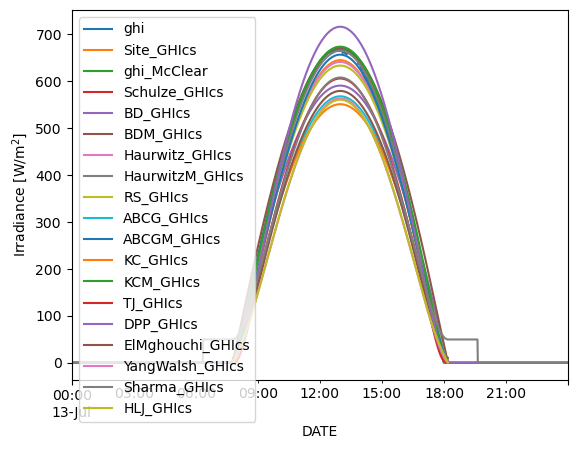

In [132]:
df.loc['2017-07-13', ['ghi','Site_GHIcs','ghi_McClear','Schulze_GHIcs','BD_GHIcs','BDM_GHIcs','Haurwitz_GHIcs','HaurwitzM_GHIcs','RS_GHIcs',
'ABCG_GHIcs','ABCGM_GHIcs','KC_GHIcs','KCM_GHIcs','TJ_GHIcs','DPP_GHIcs','ElMghouchi_GHIcs','YangWalsh_GHIcs','Sharma_GHIcs','HLJ_GHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

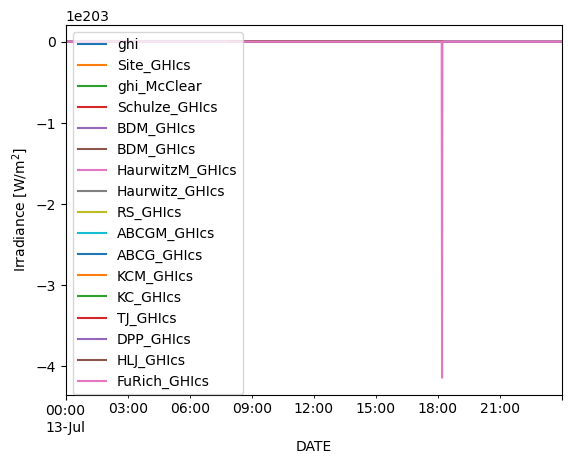

In [133]:
df.loc['2017-07-13', ['ghi','Site_GHIcs','ghi_McClear','Schulze_GHIcs','BDM_GHIcs','BDM_GHIcs','HaurwitzM_GHIcs','Haurwitz_GHIcs','RS_GHIcs',
'ABCGM_GHIcs','ABCG_GHIcs','KCM_GHIcs','KC_GHIcs','TJ_GHIcs','DPP_GHIcs','HLJ_GHIcs','FuRich_GHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

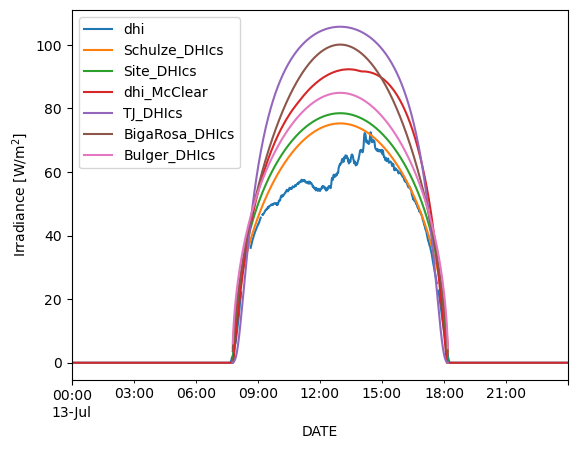

In [134]:
df.loc['2017-07-13', ['dhi','Schulze_DHIcs','Site_DHIcs','dhi_McClear','TJ_DHIcs','BigaRosa_DHIcs','Bulger_DHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

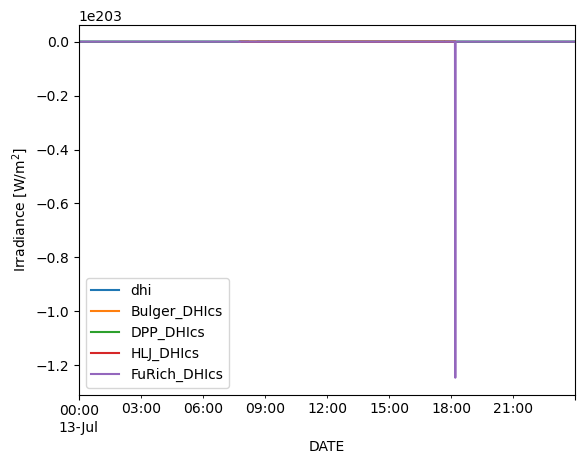

In [135]:
df.loc['2017-07-13', ['dhi','Bulger_DHIcs','DPP_DHIcs','HLJ_DHIcs','FuRich_DHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

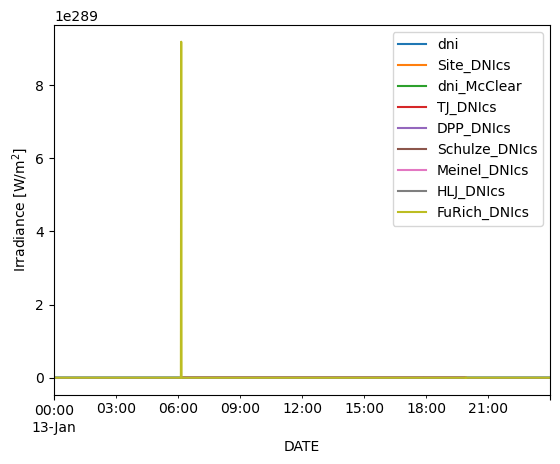

In [136]:
df.loc['2017-01-13', ['dni','Site_DNIcs','dni_McClear','TJ_DNIcs','DPP_DNIcs','Schulze_DNIcs','Meinel_DNIcs','HLJ_DNIcs','FuRich_DNIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

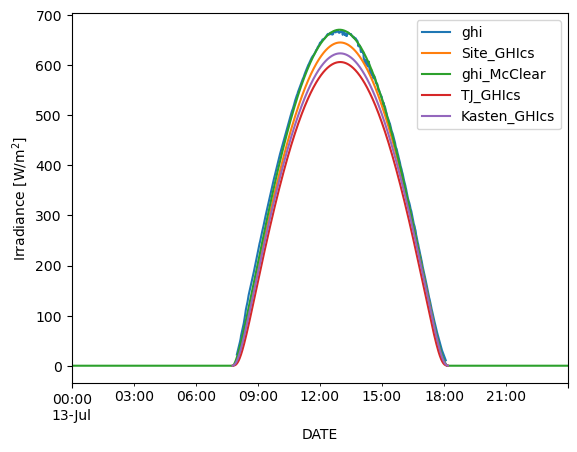

In [137]:
df.loc['2017-07-13', ['ghi','Site_GHIcs','ghi_McClear','TJ_GHIcs','Kasten_GHIcs']].plot()
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

In [138]:
df = df[(df['tcc'] <= 5) & (df['k_t'] > 0.65) & (df['zenith'] < 85)]

In [139]:
df[['dni','Site_DNIcs','Climate_DNIcs','National_DNIcs','SS_DNIcs','IP_DNIcs','BigaRosa_DNIcs','Brichambaut_DNIcs','Schulze_DNIcs','DPP_DNIcs','ESRA_DNIcs','Kumar_DNIcs','Campbell_DNIcs','Samimi_DNIcs',
'Meinel_DNIcs','Sharma_DNIcs','ElMghouchi_DNIcs','HLJ_DNIcs','FuRich_DNIcs','TJ_DNIcs','dni_McClear','Ineichen_DNIcs','Ineichen1_DNIcs','IneichenN_DNIcs','IneichenC_DNIcs','Laurie_DNIcs','Kasten_DNIcs']].to_csv('ALEX_BAY_2017_DNIc.csv')

In [140]:
df[['ghi','Site_GHIcs','Climate_GHIcs','National_GHIcs','SS_GHIcs','IP_GHIcs','BD_GHIcs','BigaRosa_GHIcs','Brichambaut_GHIcs','Schulze_GHIcs','Haurwitz_GHIcs',
'HaurwitzM_GHIcs','BDM_GHIcs','KC_GHIcs','KCM_GHIcs','ABCG_GHIcs','ABCGM_GHIcs','RS_GHIcs','DPP_GHIcs','YangWalsh_GHIcs','Sharma_GHIcs','ESRA_GHIcs',
'ElMghouchi_GHIcs','HLJ_GHIcs','FuRich_GHIcs','TJ_GHIcs','ghi_McClear','Kasten_GHIcs','Kumar_GHIcs','Campbell_GHIcs','Samimi_GHIcs','WMO1_GHIcs',
'WMO2_GHIcs','BdD_GHIcs','PdBV_GHIcs','PdBV1_GHIcs','PdBVC_GHIcs','PdBVN_GHIcs']].to_csv('ALEX_BAY_2017_GHIcX.csv')

In [141]:
df[['dhi','dhi_McClear','Site_DHIcs','Climate_DHIcs','National_DHIcs','SS_DHIcs','IP_DHIcs','BigaRosa_DHIcs','Brichambaut_DHIcs','Schulze_DHIcs','DPP_DHIcs','ESRA_DHIcs','Modtran_DHIcs',
  'Bulger_DHIcs','Sharma_DHIcs','ElMghouchi_DHIcs','HLJ_DHIcs','FuRich_DHIcs','TJ_DHIcs','Kumar_DHIcs','Campbell_DHIcs','Samimi_DHIcs','Kasten_DHIcs','Dumortier_DHIcs']].to_csv('ALEX_BAY_2017_DHIc.csv')

In [142]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ghi,109890.0,691.287181,239.025288,79.661400,508.559500,672.244500,893.062500,1154.740000
dhi,113468.0,79.228788,29.057060,20.804500,61.087550,73.530900,90.176900,459.942000
dni,113468.0,916.798522,100.706633,50.504600,858.322000,933.908000,990.906750,1131.520000
temp_air,114063.0,24.283346,5.887078,4.015000,20.280000,24.000000,28.080000,44.640000
relative_humidity,114063.0,38.805255,16.981027,3.041000,26.720000,38.780000,49.020000,100.000000
...,...,...,...,...,...,...,...,...
FD,114063.0,0.872347,0.127759,0.240011,0.803554,0.911493,0.978259,0.997450
ESRA_DHIcs,114063.0,133.445019,31.188533,31.333365,108.702606,133.841879,161.759418,182.209908
rot,114063.0,0.109003,0.009202,0.057908,0.103799,0.110459,0.116527,0.120876
ESRA_DNIcs,114063.0,756.704260,105.905925,191.774722,696.183204,782.475010,841.192949,907.816984


In [143]:
df.columns

Index(['ghi', 'dhi', 'dni', 'temp_air', 'relative_humidity', 'tcc',
       'solar_zenith', 'cos_solar_zenith', 'dni_extra', 'ghi_extra',
       ...
       'Modtran_DHIcs', 'TRD', 'a0', 'a1', 'a2', 'FD', 'ESRA_DHIcs', 'rot',
       'ESRA_DNIcs', 'ESRA_GHIcs'],
      dtype='object', length=114)

<Axes: xlabel='DATE'>

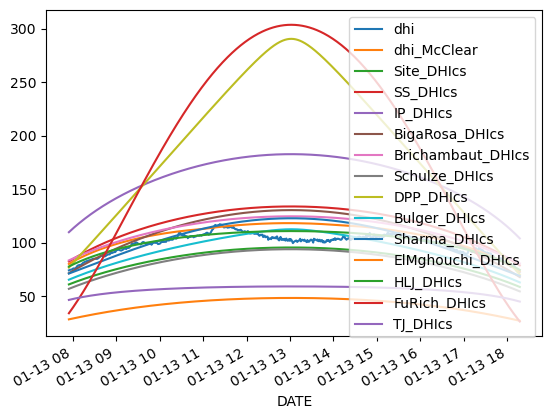

In [144]:
df.loc['2017-01-13',['dhi','dhi_McClear','Site_DHIcs','SS_DHIcs','IP_DHIcs','BigaRosa_DHIcs','Brichambaut_DHIcs','Schulze_DHIcs','DPP_DHIcs',
  'Bulger_DHIcs','Sharma_DHIcs','ElMghouchi_DHIcs','HLJ_DHIcs','FuRich_DHIcs','TJ_DHIcs']].plot()

<Axes: xlabel='DATE'>

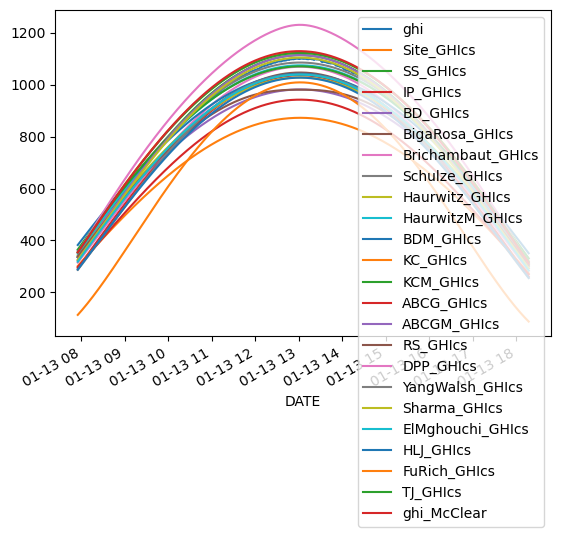

In [145]:
df.loc['2017-01-13',['ghi','Site_GHIcs','SS_GHIcs','IP_GHIcs','BD_GHIcs','BigaRosa_GHIcs','Brichambaut_GHIcs','Schulze_GHIcs','Haurwitz_GHIcs',
'HaurwitzM_GHIcs','BDM_GHIcs','KC_GHIcs','KCM_GHIcs','ABCG_GHIcs','ABCGM_GHIcs','RS_GHIcs','DPP_GHIcs','YangWalsh_GHIcs',
'Sharma_GHIcs','ElMghouchi_GHIcs','HLJ_GHIcs','FuRich_GHIcs','TJ_GHIcs','ghi_McClear']].plot()

<Axes: xlabel='DATE'>

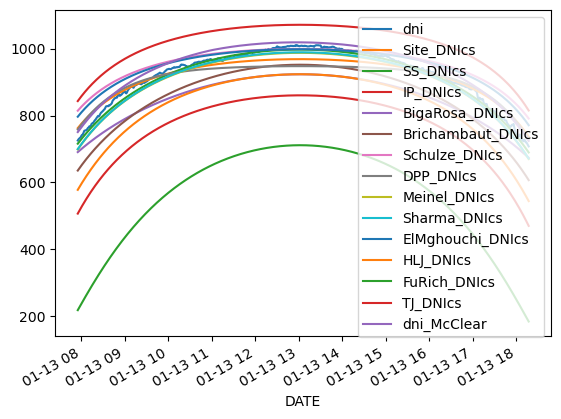

In [146]:
df.loc['2017-01-13',['dni','Site_DNIcs','SS_DNIcs','IP_DNIcs','BigaRosa_DNIcs','Brichambaut_DNIcs','Schulze_DNIcs','DPP_DNIcs',
'Meinel_DNIcs','Sharma_DNIcs','ElMghouchi_DNIcs','HLJ_DNIcs','FuRich_DNIcs','TJ_DNIcs','dni_McClear']].plot()

In [147]:
# Assuming df is your DataFrame with all the columns
# Filter the DataFrame to only include columns with 'DNIcs' in their names
#df_filtered = df.filter(like='DHIcs')

# Display the filtered DataFrame columns
#print(df_filtered.columns)